In [20]:
import nflgame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Get Data

In [3]:
# NFL Games for 2016
games = nflgame.games(2016)

In [4]:
players = nflgame.combine_game_stats(games)

In [5]:
# Get the Top 50 players who have the most rushing yards from the 2016 season
top50 = []
for p in players.rushing().sort('rushing_yds').limit(50):
    top50.append(p)

In [103]:
# Build DataFrame - Index for Player name and week #
top50_names = [str(p.name) for p in top50]
wks = range(1,18)
idxs = [top50_names, wks]

idx = pd.MultiIndex.from_product(idxs, names=['name', 'week'])
columns = [
    'rushing_att', 
    'rushing_yds', 
    'rushing_tds', 
    'fumbles_tot',
    'home',
    'DNP',
    'fantasy_points'
]
df = pd.DataFrame(data=None, index=idx, columns=columns)

In [104]:
df.head()

rushing_att rushing_yds rushing_tds fumbles_tot home  \
name      week                                                        
E.Elliott 1            NaN         NaN         NaN         NaN  NaN   
          2            NaN         NaN         NaN         NaN  NaN   
          3            NaN         NaN         NaN         NaN  NaN   
          4            NaN         NaN         NaN         NaN  NaN   
          5            NaN         NaN         NaN         NaN  NaN   

               fantasy_points  
name      week                 
E.Elliott 1               NaN  
          2               NaN  
          3               NaN  
          4               NaN  
          5               NaN

In [105]:
# Update DF with stats for Top 50 players for all games
for g in games:
    wk = g.schedule['week']
    for p in g.players.rushing():
        
        # Check if top50 player
        if p.name in df.index:
            df.loc[(p.name, wk), 'rushing_att'] = p.rushing_att
            df.loc[(p.name, wk), 'rushing_yds'] = p.rushing_yds
            df.loc[(p.name, wk), 'rushing_tds'] = p.rushing_tds
            df.loc[(p.name, wk), 'fumbles_tot'] = p.fumbles_tot
            df.loc[(p.name, wk), 'home'] = p.home

In [122]:
# DNP
df.loc[df['fantasy_points'].isnull(), 'DNP'] = True
df.loc[df['fantasy_points'].notnull(), 'DNP'] = False

# Fill NaNs
df = df.fillna(0)

# Boolean Values to int
df['home'] = df['home'].astype('int')
df['DNP'] = df['DNP'].astype('int')

In [123]:
# Calculate Fantasy Points
df['fantasy_points'] = df['rushing_yds'] * .1 + df['rushing_tds'] * 6 - df['fumbles_tot'] * 2

In [124]:
df.head(17)

rushing_att  rushing_yds  rushing_tds  fumbles_tot  home  \
name      week                                                             
E.Elliott 1              20           51            1            0     1   
          2              21           83            1            2     0   
          3              30          140            0            0     1   
          4              23          138            1            0     0   
          5              15          134            2            0     1   
          6              28          157            0            0     0   
          7               0            0            0            0     0   
          8              22           96            0            0     1   
          9              18           92            2            1     0   
          10             21          114            2            0     0   
          11             25           97            0            0     1   
          12             20           97            2            0     1   
          13             20           86            1            1     0   
          14             24          107            0            0     0   
          15             23          159            1            1     1   
          16             12           80            2            0     1   
          17              0            0            0            0     0   

                fantasy_points  DNP  
name      week                       
E.Elliott 1               11.1    0  
          2               10.3    0  
          3               14.0    0  
          4               19.8    0  
          5               25.4    0  
          6               15.7    0  
          7                0.0    1  
          8                9.6    0  
          9               19.2    0  
          10              23.4    0  
          11               9.7    0  
          12              21.7    0  
          13              12.6    0  
          14              10.7    0  
          15              19.9    0  
          16              20.0    0  
          17               0.0    1

# Format Data

In [11]:
# TODO
df = df.fillna(0)
df_pivot = df.unstack(level=-1)
df_pivot

rushing_att                                      ...   \
week                  1   2   3   4   5   6   7   8   9   10  ...    
name                                                          ...    
A.Blue                 1   5   2   3   6   2  11   9   0   7  ...    
A.Rodgers              4   3   5   0   5   3   2   6   6   3  ...    
B.Powell               4   1   4   4   4   3   4   6   6   4  ...    
C.Anderson            20  20  14  19  11  10  16   0   0   0  ...    
C.Hyde                23  14  21  15  22  14   0   0   0  13  ...    
C.Ivory                0   0  12   8   0  11   5   4  18   9  ...    
C.Kaepernick           0   0   0   0   0   8   9   0   5  10  ...    
C.Michael             15  10  20  18   0  18  16  10   5   5  ...    
D.Booker               3   9   4   7   6   5  17  19  10  24  ...    
D.Freeman             11  17  14  13  23  12  15  11  17  12  ...    
D.Henry                5   9  10   3   7   2   1  16   0   9  ...    
D.Johnson             16  12  10  17   4  22  33  10   0  19  ...    
D.Martin              18   7   0   0   0   0   0   0   0  16  ...    
D.Murray              13  12  16  25  27  21  25  21  14  17  ...    
D.Sproles              5  12   2   0   5   4   3  15  13   2  ...    
D.Washington           2   6   6   2   9  10   5   5  10   0  ...    
E.Elliott             20  21  30  23  15  28   0  22  18  21  ...    
F.Gore                14  13  21  16  14  22  17   9  19   0  ...    
I.Crowell             12  18  15  15  13   9  12  11   6   9  ...    
J.Ajayi                0   5   7   6  13  25  29   0  24  19  ...    
J.Hill                 9  11  17  21   4  13   9  20   0  15  ...    
J.Howard               0   3   9  23  16  15   7  26   0  15  ...    
J.McKinnon             1   2  16  18  20   0  11   0   7   6  ...    
J.Richard              3   7   6   2   8   4   1   5   8   0  ...    
J.Rodgers              0   2   5   6  30   0  26  19   0   0  ...    
J.Stewart             15   5   0   0   0  19   0  25  15  13  ...    
K.Dixon                0   0   0   0   3   2   1   0   9   6  ...    
L.Bell                 0   0   0  18  20  10  21   0  14  17  ...    
L.Blount              22  29  24  13  18  13  24  18   0  21  ...    
L.McCoy               16  15  17  19  18  19   8   0  21   0  ...    
L.Miller              28  25  21  19   8  24  11  17   0  15  ...    
L.Murray              14   8  10   8   0   0  18  11  20   0  ...    
M.Asiata               4   6   6   6  14   0  12  14   9   9  ...    
M.Forte               22  30  15  14  12   9  30  25  12  20  ...    
M.Gillislee            0   0   3   6   2   6   5  12   8   0  ...    
M.Gordon              14  24  16  19  16  27  22  23  32  24  ...    
M.Ingram              12   9  15  18   0  16  16   3  15  11  ...    
M.Jones                7  13  17  22  14  16  10   0   0   0  ...    
P.Perkins              0   0   0   2   2   2   4   0  11   9  ...    
R.Jennings            18  13   0   0   0   9  13   0  11  15  ...    
R.Kelley               0   0   4   1   3   5   4  21   0  22  ...    
R.Mathews             22   9   2   0  11   9  14   4   5  19  ...    
S.Ware                11  10  20  13   0  24  17   7   0  13  ...    
T.Coleman              8  12  12   8   6   5   8   0   0   0  ...    
T.Gurley              17  19  27  19  23  14  15   0  12  21  ...    
T.Hightower            4   3   3   4   0   0   5  26  23   8  ...    
T.Montgomery           0   0   1   0   1   3   9   0   7   3  ...    
T.Taylor               5   2   9   5   5   8   7   5   8   0  ...    
T.West                12  11  10  21  11  23   8   0  15  21  ...    
T.Yeldon              21   7   6  14   0   6   6   3   7   9  ...    

             fantasy_points                                                  \
week                     8     9     10    11    12    13    14    15    16   
name                                                                          
A.Blue                  4.1   0.0   2.3   0.0   0.0   3.8   3.5  

In [12]:
# Build Dataframe sorted by Week
stat_categories = ['rushing_att', 'rushing_yds', 'rushing_tds', 'fumbles_tot', 'fantasy_points']
wks = range(1,18)
columns = ['{0}_{1}'.format(wk, c) for wk in wks for c in stat_categories]
df_ = pd.DataFrame(0, index=df_pivot.index, columns=columns)

In [13]:
# Sort Data from df_pivot by week
for wk in wks:
    for c in stat_categories:
        column_name = '{0}_{1}'.format(wk, c)
        df_[column_name] = df_pivot[c][wk]
df_

,1_rushing_att,1_rushing_yds,1_rushing_tds,1_fumbles_tot,1_fantasy_points,2_rushing_att,2_rushing_yds,2_rushing_tds,2_fumbles_tot,2_fantasy_points,...,16_rushing_att,16_rushing_yds,16_rushing_tds,16_fumbles_tot,16_fantasy_points,17_rushing_att,17_rushing_yds,17_rushing_tds,17_fumbles_tot,17_fantasy_points
name,,,,,,,,,,,,,,,,,,,,,
A.Blue,1,4,0,0,0.4,5,11,0,0,1.1,...,21,73,1,0,13.3,11,28,0,0,2.8
A.Rodgers,4,16,1,0,7.6,3,29,1,3,2.9,...,2,13,1,0,7.3,10,42,0,0,4.2
B.Powell,4,41,0,0,4.1,1,2,0,0,0.2,...,15,60,0,0,6.0,22,122,0,0,12.2
C.Anderson,20,92,1,0,15.2,20,74,1,0,13.4,...,0,0,0,0,0.0,0,0,0,0,0.0
C.Hyde,23,88,2,0,20.8,14,34,0,1,1.4,...,13,38,0,2,-0.2,0,0,0,0,0.0
C.Ivory,0,0,0,0,0.0,0,0,0,0,0.0,...,14,45,1,1,8.5,0,0,0,0,0.0
C.Kaepernick,0,0,0,0,0.0,0,0,0,0,0.0,...,6,15,1,0,7.5,5,16,0,2,-2.4
C.Michael,15,66,0,0,6.6,10,60,0,1,4.0,...,4,4,0,0,0.4,3,6,0,0,0.6
D.Booker,3,8,0,1,-1.2,9,46,0,0,4.6,...,5,27,0,1,0.7,14,57,1,0,11.7


# Train Test Split

In [14]:
def create_dataset(dataset, games_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - games_back - 1):
        a = dataset[i:(i + games_back), :]
        dataX.append(a)
        
        # Last Game's fantasy points
        dataY.append(dataset[i + games_back, -1])
    return np.array(dataX), np.array(dataY)

In [47]:
# Build Dataset
X = np.array([])
Y = np.array([])
games_back = 4
for player in set(df.index.get_level_values(0)):
    data = df.loc[player].values
    X_, Y_ = create_dataset(data, games_back=games_back)
    if len(X) == 0 and len(Y) == 0:
        X = X_
        Y = Y_
    else:
        X = np.append(X, X_, axis=0)
        Y = np.append(Y, Y_, axis=0)
print(X)

[[[ 15.   64.    0.    0.    6.4]
  [  5.    9.    0.    0.    0.9]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]]

 [[  5.    9.    0.    0.    0.9]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]]

 [[  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]
  [ 19.   85.    2.    0.   20.5]]

 ..., 
 [[ 19.   79.    0.    0.    7.9]
  [ 16.   77.    0.    0.    7.7]
  [ 18.   45.    1.    0.   10.5]
  [ 12.   61.    0.    0.    6.1]]

 [[ 16.   77.    0.    0.    7.7]
  [ 18.   45.    1.    0.   10.5]
  [ 12.   61.    0.    0.    6.1]
  [ 20.   48.    0.    1.    2.8]]

 [[ 18.   45.    1.    0.   10.5]
  [ 12.   61.    0.    0.    6.1]
  [ 20.   48.    0.    1.    2.8]
  [ 19.   51.    0.    1.    3.1]]]


In [48]:
# Train / Test Split
split = .67
train_sizeX = int(len(X) * split)
train_sizeY = int(len(Y) * split)
test_sizeX = int(len(X) * (1 - split))
test_sizeY = int(len(Y) * (1 - split))

trainX = X[:train_sizeX]
trainY = Y[:train_sizeY]
testX = X[train_sizeX:]
testY = Y[train_sizeY:]

# Build Model

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

column_nums = len(df.columns)
model = Sequential()
model.add(LSTM(4, input_dim=column_nums))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/Users/bvz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(None, 5))`
  import sys


# Train Model

In [50]:
model.fit(trainX, trainY, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 76.5695
Epoch 2/10
4s - loss: 61.4890
Epoch 3/10
4s - loss: 51.9672
Epoch 4/10
4s - loss: 48.3326
Epoch 5/10
4s - loss: 46.1348
Epoch 6/10
4s - loss: 44.7053
Epoch 7/10
4s - loss: 43.7583
Epoch 8/10
4s - loss: 43.1685
Epoch 9/10
4s - loss: 42.6561
Epoch 10/10
4s - loss: 42.2797


# Analyze Model

In [51]:
# Train Score
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore

6.4832212271694205

In [52]:
# Test Score
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore

7.621865990508866

In [53]:
# Predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

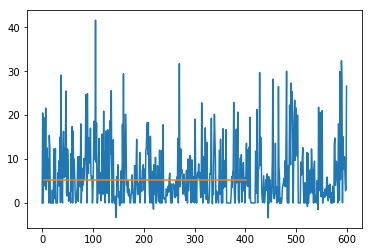

In [54]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(trainY)
trainPredictPlot[:] = np.nan 
trainPredictPlot[games_back:len(trainPredict)+games_back] = trainPredict[0]
# shift test predictions for plotting
testPredictPlot = np.empty_like(testY)
testPredictPlot[:] = np.nan 
testPredictPlot[len(trainPredict)+(games_back*2)+1:len(Y)-1] = testPredict[0] # plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

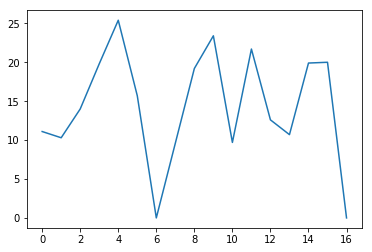

In [56]:
Y_fps = df.loc['E.Elliott']['fantasy_points'].values
plt.plot(Y_fps)
plt.show()

In [87]:
def plotPlayerPredictions(df, games_back=4, model=None, player=''):
    X_, Y_ = create_dataset(df.values, games_back=games_back)
    
    if model:
        Y_pred = model.predict(X_)
        # Prepend Prediction with 0's for games not predicted
        Y = np.insert(Y_pred, 0, values=[0] * games_back)
        plt.title(player)
        plt.plot(df['fantasy_points'].values)
        plt.plot(Y)
        plt.show()
        

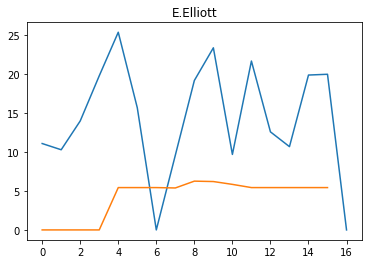

In [88]:
player = 'E.Elliott'
plotPlayerPredictions(df.loc[player], model=model, player=player)

In [86]:
[0] * 4

[0, 0, 0, 0]